In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

SystemExit: interrupted

In [12]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

In [13]:
death_table = pd.read_csv('UkWideData/EnglandandWalesDeaths.csv', sep=',').transpose()
DeathNP=np.zeros((16,11))
DeathSummedNP=np.zeros((16,11))
for i in range(0, 16):
    DeathNP[i]=death_table[i+1].values[1:].astype(int)+0.01
for i in range(16, 19):
    DeathNP[15]=DeathNP[15]+death_table[i+1].values[1:].astype(int)

for i in range(0, 16):
    DeathSummedNP[i][0]=DeathNP[i][0]
    for j in range(1, 11):
        DeathSummedNP[i][j]=DeathSummedNP[i][j-1]+DeathNP[i][j]

#population data is loaded

resident_data_2018_raw = pd.read_csv('UkWideData/EWAgeDistributed.csv')

M  = 16              # the population has 16 age groups due to the contact matrix being only 16 age groups
# correct params in 1/week, beta is just guessed
beta  = 3               # infection rate
gE    = 1/2.72*7        # exposed to activated rate
gA    = 1/3.12*7        # activated to infected rate
gIa   = 1./7*7        # recovery rate of asymptomatic infectives
gIs   = 1./17.76*7       # To hospital
   # fsa   = 1         # the self-isolation parameter (assumed to be known but really isn't) and so I am not using it here

    
#Here we load the residential data
Ni=np.zeros(len(resident_data_2018_raw['Num'])-3)
for i in range(0, len(Ni)):
    Ni[i]=resident_data_2018_raw['Num'][i]
Ni[15]=Ni[15]+resident_data_2018_raw['Num'][16]
Ni[15]=Ni[15]+resident_data_2018_raw['Num'][17]
Ni[15]=Ni[15]+resident_data_2018_raw['Num'][18]
N = np.sum(Ni)
fi = Ni/N 

#These are gained from the italian data
alphaIni = np.array([0.63358955, 0.57383754, 0.51972058, 0.42631619, 0.47070723, 0.38611154, 0.34969848, 0.31671942, 0.28685053, 0.25979848, 0.23529764, 0.21310739, 0.19300985, 0.17480765, 0.15832204, 0.14339115, 0.12986834, 0.11762083, 0.10652835])
alpha=np.zeros(M)
for i in range(0, M-1):
    alpha[i]=alphaIni[i]
alpha[M-1]=(alphaIni[15]*resident_data_2018_raw['Num'][15]+alphaIni[16]*resident_data_2018_raw['Num'][16]+alphaIni[17]*resident_data_2018_raw['Num'][17]+alphaIni[18]*resident_data_2018_raw['Num'][18])/Ni[15]
cfrIni=np.array([2.19622061e-03, 1.87465592e-05, 1.27008458e-04, 4.37298924e-04, 1.09205604e-03, 2.25919511e-03, 4.12922192e-03, 6.91320146e-03, 1.08412222e-02, 1.61611801e-02, 2.31377823e-02, 3.20517124e-02, 4.31989157e-02, 5.68899781e-02, 7.34495808e-02, 9.32160148e-02, 1.16540746e-01, 1.43788021e-01, 1.75334511e-01])
cfr=np.zeros(M)
for i in range(0, M-1):
    cfr[i]=cfrIni[i]
cfr[M-1]=(cfrIni[15]*resident_data_2018_raw['Num'][15]+cfrIni[16]*resident_data_2018_raw['Num'][16]+cfrIni[17]*resident_data_2018_raw['Num'][17]+cfrIni[18]*resident_data_2018_raw['Num'][18])/Ni[15]

#basically educated guesses that should be verified
sus= np.array([0.2, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1, 1,  1, 1,1])
immune= np.array([0.3, 0.4, 0.3, 0.25, 0.22, 0.2, 0.17, 0.15, 0.12, 0.1, 0.07, 0.05, 0.02, 0.01, 0.005, 0.001])

#Here we load the contact matrix

CH0, CW0, CS0, CO0 =pyross.contactMatrix.UK()
#I make the questionable decision to sum the contact matrices
C = CO0+CS0+CH0+CW0    

#We define the model in here in the vein of Spp.

model_spec = {
    "classes" : ["S", "E", "A", "Ia", "Is", "Im"],

    "S" : {
        "linear"    : [["Ia", "immune*gammaIa"]],
        "infection" : [ ["A", "-betaEffec"], ["Ia", "-betaEffec"], ["Is", "-betaEffec"] ]
    },

    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["A", "betaEffec"], ["Ia", "betaEffec"], ["Is", "betaEffec"] ]
    },
    
    "A" : {
        "linear"    : [ ["E", "gammaE"], ["A", "-alphabar*gammaA"], ["A", "-alpha*gammaA"] ],
        "infection" : [ ]
    },

    "Ia" : {
        "linear"    : [ ["A", "alpha*gammaA"], ["Ia", "-immune*gammaIa"], ["Ia", "-immunebar*gammaIa"] ],
        "infection" : [ ]
    },
    
    "Is" : {
        "linear"    : [ ["A", "alphabar*gammaA"], ["Is", "-cfrbar*gammaIs"], ["Is", "-cfr*gammaIs"] ],
        "infection" : [ ]
    },
    
    "Im" : {
        "linear"    : [ ["Is", "cfr*gammaIs"] ],
        "infection" : [ ]
    }
}
M=16

    
def contactMatrix(t):
    return C


In [7]:
#Which weeks are we looking at
T1 = 0 
T2 = 4

steps=20


DeathNP=DeathNP[:,T1:T2]
DeathSummedNP=DeathSummedNP[:,T1:T2]

recov=DeathNP/cfr[:,None]*(1-cfr[:,None])
symptomatic=DeathNP/cfr[:,None]
asymptomatic=symptomatic*alpha[:,None]/(1-alpha[:,None])    
activated=symptomatic/(1-alpha[:,None])


# set up initial condition, ideally you want nonzero values everywhere otherwise the optimiser can be rather unhappy for some reason.
E0   = activated.transpose()[3]/20
A0   = activated.transpose()[3]/30
Ia0  = asymptomatic.transpose()[2]/15 
Is0  = (symptomatic.transpose()[1])/15
R0   = symptomatic.transpose()[0]+ (asymptomatic.transpose()[0]+asymptomatic.transpose()[1])
S0   = Ni - (E0 + A0 + Ia0 + Is0  + DeathNP.transpose()[0] + R0)
        
#This is your observed quantity
obs=DeathSummedNP
obs=obs.transpose()
obs=obs/N

#Now we look at the bounds for all the categories that we did not observe
beta_std = 0.5
#array
beta_g =sus*5

beta_bounds = (0.1, 10)
#We want to be bounded at least by 1 person in every class, otherwise it can have problems and go negative
BoundsArray=np.ones(M)/100
if(E0[1]>10):
    E0_g = (E0)/N
else:
    E0_g=np.array([30/N]*M)
E_std = E0_g*0.5 
if(E0_g[0]>10/N):
    bounds_for_E = np.array([E0_g/3,E0_g*4/3+Ni/N/35]).transpose()
else:
    bounds_for_E = np.array([BoundsArray/N,Ni/20/N]).transpose()

if(A0[1]>10):
    A0_g = (A0)/N
else:
    A0_g=np.array([20/N]*M)
A_std = A0_g*0.5
if(A0_g[0]>10/N):
    bounds_for_A = np.array([A0_g/3,A0_g*4/3+Ni/N/35]).transpose()
else:
    bounds_for_A = np.array([BoundsArray/N,Ni/20/N]).transpose()

if(Ia0[1]>10):
    Ia0_g = (Ia0)/N
else:
    Ia0_g=np.array([5/N]*M)
Ia_std = Ia0_g*0.5
if(Ia0_g[0]>10/N):
    bounds_for_Ia = np.array([Ia0_g/3,Ia0_g*4/3+Ni/N/35]).transpose()
else:
    bounds_for_Ia = np.array([BoundsArray/N,Ni/20/N]).transpose()

if(Is0[1]>10):
    Is0_g = (Is0)/N
else:
    Is0_g=np.array([5/N]*M)
Is_std = Is0_g*0.5
if(Is0_g[1]>10/N):
    bounds_for_Is = np.array([Is0_g/3,Is0_g*4/3+Ni/N/35]).transpose()
else:
    bounds_for_Is = np.array([BoundsArray/N,Ni/20/N]).transpose()

S0_g = (S0)/N
if(np.all(S0-Ni<-0.01-10/N)):
    S_std = S0_g*0.01+10/N
else:
    S_std = Ni-S0/N
bounds_for_S = np.array([0.9*S0_g,Ni/N]).transpose()

 #For simulation
x0=np.array([S0_g, E0_g, A0_g, Ia0_g, Is0_g, (DeathSummedNP.transpose()[0])/N])
#For inference
#     x0=np.array([S0_g, E0_g, A0_g, Ia0_g, Is0_g])
x0=x0.flatten()

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

fltr=np.kron(([0, 0, 0, 0, 0, 1]), np.identity(M))
parameters ={
    'betaEffec' : sus*0.7,
    'gammaE' : gE,
    'alpha*gammaA' : alpha*gA,
    'alphabar*gammaA' : (1 - alpha)*gA,
    'immunebar*gammaIa' : gIa*(1-immune),
    'immune*gammaIa' : gIa*(immune),
    'cfrbar*gammaIs': (1-cfr)*gIs,
    'cfr*gammaIs': (cfr)*gIs
}

# set up bounds, guess and stds for the rest of the params 
bounds = np.array([beta_bounds, *bounds_for_S,  *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is ])
guess = np.array([beta_g,  *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g])
stds = np.array([beta_std, *S_std, *E_std, *A_std, *Ia_std, *Is_std])
init_fltr = np.repeat([ True, True, True, True, True, False], M)
param_keys = ['betaEffec']
start_time = time.time()
#uncomment to properly run optimisations, currently commented due to everything on pyross being run every time things are pushed and this takes a while to run
estimator = pyross.inference.Spp(model_spec, parameters, M, fi, int(N), T2-T1)
params = estimator.latent_infer_parameters(param_keys, init_fltr, guess, stds, obs, fltr,  T2-T1-1,  T2-T1, contactMatrix, bounds, global_max_iter=150, global_ftol_factor=1e3, verbose=True, ftol=ftol,local_max_iter=500, tangent=True, infer_scale_parameter=True)
partial_inits = params[len(param_keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
best_estimates = estimator.fill_params_dict(param_keys, params)
det_model = pyross.deterministic.Spp(model_spec, best_estimates, int(M), fi)
x_det = det_model.simulate(x0, contactMatrix, T2-T1-1, T2-T1)
data_array=x_det['X']
b=best_estimates['betaEffec']/sus



Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 81 (seed=2666226514, Thu May 28 10:13:34 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 6.148019032289208e+29 1.0e+00 9.56e-01  2e-10  5e-01 0:00.7
    2     32 3.054048979951874e+06 1.0e+00 9.23e-01  2e-10  5e-01 0:01.4
    3     48 4.433718794892338e+23 1.0e+00 8.97e-01  2e-10  4e-01 0:01.9
    9    144 5.794184878611091e+06 1.1e+00 8.23e-01  2e-10  4e-01 0:05.2
   17    272 8.408349098165450e+03 1.1e+00 8.09e-01  2e-10  4e-01 0:09.2
Optimal value (global minimisation):  8167.637161343265
Starting local minimisation...
Optimal value (local minimisation):  935.1339877370829


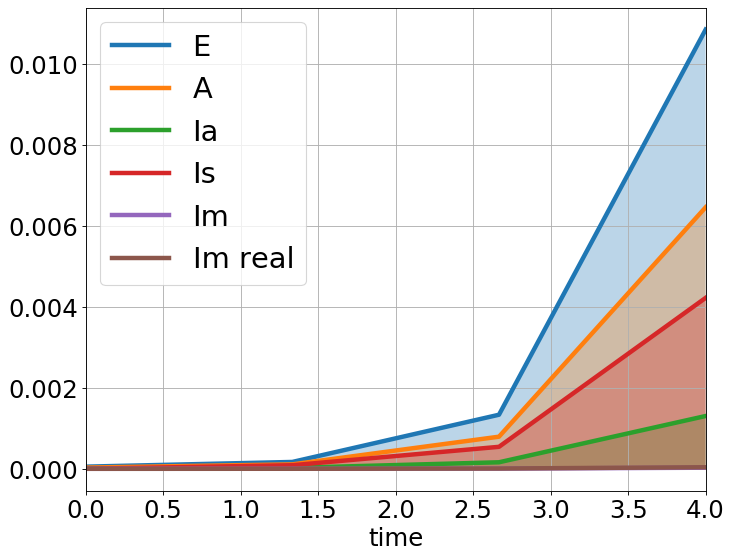

In [11]:
det_model = pyross.deterministic.Spp(model_spec, best_estimates, int(M), fi)
x_det = det_model.simulate(x0, contactMatrix, T2-T1-1, T2-T1)

data_array=x_det['X']
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = np.linspace(0,T2-T1,T2-T1)

# plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
# plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='E', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='A', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 3*M:4*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 4*M:5*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 4*M:5*M], axis=1), '-', label='Is', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 5*M:6*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 5*M:6*M], axis=1), '-', label='Im', lw=4)

plt.fill_between(t, 0, np.sum(DeathSummedNP[0:M,:].transpose(), axis=1)/N, alpha=0.3)
plt.plot(t, np.sum(DeathSummedNP[0:M,:].transpose(), axis=1)/N, '-', label='Im real', lw=4)



plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)
plt.savefig("Showcase.png")